In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras import regularizers
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pickle
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2
from keras.models import load_model
from PyFunctions import Viz
from PyFunctions import Functions as func

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
dim = (224, 224)

x_train, x_test, y_train, y_test, x_val, y_val = func.get_mask_splits(dim)

TRAIN Value Counts
1    5000
0    5000
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
TEST Value Counts
0    509
1    483
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
VALIDATION Value Counts
1    400
0    400
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [3]:
def get_mobilenet(dim):
    model = Sequential()
    optimizer = Adam(lr = .0005)
    baseModel = MobileNetV2(weights = 'imagenet', include_top = False, input_tensor = Input(shape = dim))

    model.add(baseModel)
    model.add(AveragePooling2D(pool_size = (7, 7)))
    model.add(Flatten(name = 'flatten'))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.6))
    model.add(Dense(2, activation = 'sigmoid', name = 'Output'))

    for layer in baseModel.layers:
        layer.trainable = False
    
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model
    

In [4]:
early_stopping = EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 5, min_delta = .00075)
model_checkpoint = ModelCheckpoint(f'ModelWeights/Mobilenet_Masks.h5', verbose = 1, save_best_only = True, monitor = 'val_loss')
lr_plot = ReduceLROnPlateau(patience = 5, mode = 'min')
epochs = 2000
batch_size = 64

dim = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
mobilenet = get_mobilenet(dim = dim)

augmentation = ImageDataGenerator(rotation_range = 20, width_shift_range = .2, height_shift_range = .2, horizontal_flip = True, shear_range = .15, fill_mode = 'nearest', zoom_range = .15)
augmentation_history = mobilenet.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size), epochs = epochs, callbacks = [early_stopping, model_checkpoint, lr_plot], validation_data = [x_test, y_test], verbose = 1)

2023-02-18 18:27:30.065520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/alanwang/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/var/folders/g9/s15kjggj0bb9t_61f58dny800000gn/T/ipykernel_23328/223381710.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  augmentation_history = mobilenet.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size), epochs = epochs, callbacks = [early_stopping, model_checkpoint, lr_plot], validation_data = [x_test, y_test]

Epoch 1/2000
157/157 [==============================] - ETA: 0s - loss: 0.1187 - accuracy: 0.9582
Epoch 1: val_loss improved from inf to 0.04306, saving model to ModelWeights/Mobilenet_Masks.h5
157/157 [==============================] - 203s 1s/step - loss: 0.1187 - accuracy: 0.9582 - val_loss: 0.0431 - val_accuracy: 0.9819 - lr: 5.0000e-04
Epoch 2/2000
157/157 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 0.9840
Epoch 2: val_loss improved from 0.04306 to 0.03308, saving model to ModelWeights/Mobilenet_Masks.h5
157/157 [==============================] - 194s 1s/step - loss: 0.0510 - accuracy: 0.9840 - val_loss: 0.0331 - val_accuracy: 0.9899 - lr: 5.0000e-04
Epoch 3/2000
157/157 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9886
Epoch 3: val_loss did not improve from 0.03308
157/157 [==============================] - 187s 1s/step - loss: 0.0349 - accuracy: 0.9886 - val_loss: 0.0378 - val_accuracy: 0.9839 - lr: 5.0000e-04
Epoch 4/2000
157

In [13]:
Viz.plot_loss_accuracy(augmentation_history, 'dark_background', path = 'Images/Mobilenet_Loss_Acc.png')

KeyError: 'acc'

25/25 [==============================] - 9s 341ms/step
F1 Scores Test
~~~~~~~~~~~~~~~~~~~
No Mask(0): 0.9962453066332916
Mask(1): 0.9962546816479401


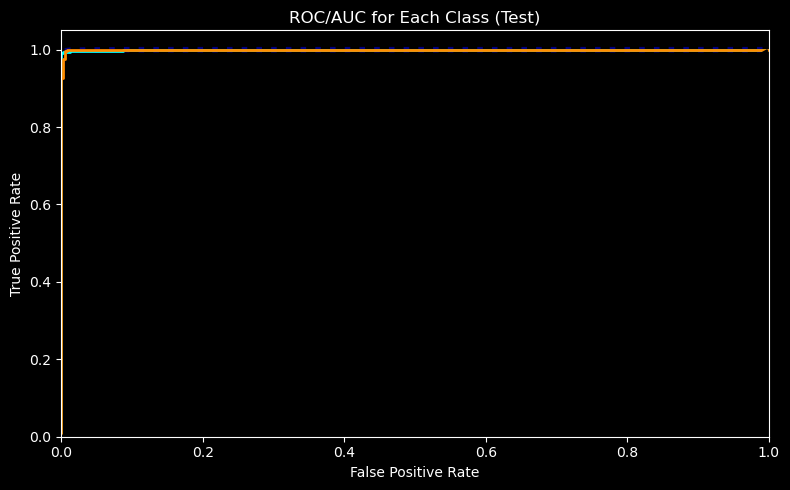

In [8]:
mobilenet = load_model('ModelWeights/Mobilenet_Masks.h5')
Viz.plot_roc_auc(mobilenet, x_val, y_val, 'dark_background', 'mask', path = 'Images/Mobilenet_ROC.png')

25/25 [==============================] - 9s 350ms/step


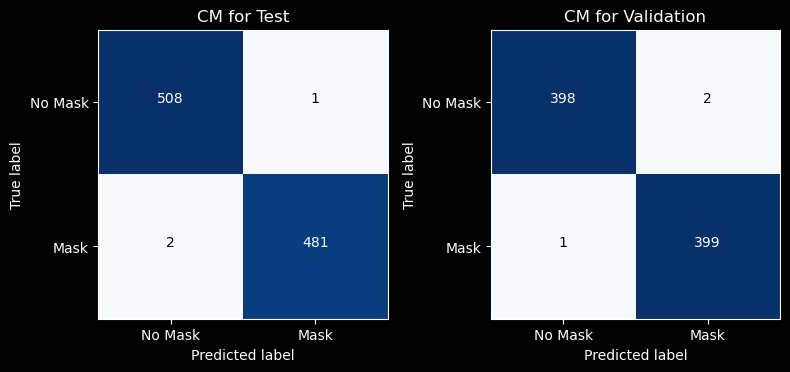

In [10]:
mobilenet = load_model('ModelWeights/Mobilenet_Masks.h5')
y_test_prob = [np.argmax(i) for i in mobilenet.predict(x_test)]
y_test_labels = [np.argmax(i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

val_prob = [np.argmax(i) for i in mobilenet.predict(x_val)]
val_labels = [np.argmax(i) for i in y_val]
val_cnf = confusion_matrix(val_labels, val_prob)

# this function creates a confusion matrix given the confusion matrices of test and train
Viz.plot_model_cm(test_cnf, val_cnf, classes = ['No Mask', 'Mask'], theme = 'dark_background', model_type = 'mask', path = 'Images/Mobilenet_CM.png')

In [11]:
assert False

AssertionError: 

In [12]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>